# Mixtures of Gaussian Processes with gpclust


This notebook accompanies the paper

**Nonparameteric Clustering of Structured Time Series**  
_James Hensman, Magnus Rattray and Neil D. Lawrence_  
IEEE TPAMI 2014

The code is available at <https://github.com/mathDR/gpclust> . The gpclust module depends on [gpflow](https://github.com/GPflow).  

The hierachical Gaussian process model was fleshed out in 

**Hierarchical Bayesian modelling of gene expression time series  
across irregularly sampled replicates and clusters**  
_James Hensman, Neil D. Lawrence and Magnus Rattray_

http://www.biomedcentral.com/1471-2105/14/252



In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'#'svg' would be better, but eats memory for these big plots.
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import numpy as np
import random
import gpclust
import gpflow
np.random.seed(0)

## A simple point process dataset

Here's a simulated dataset that contains the simple features that we expect to have in real data sets: . 

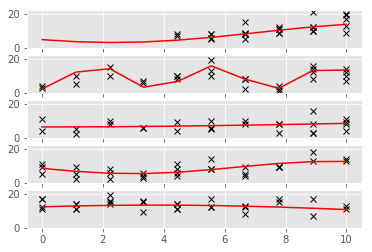

In [2]:
PLOTTING = True
Nclust = 5
Nobs = [np.random.randint(5,7) for i in range(Nclust)]
N = 10
times = np.linspace(0,10,N)
X = []
Y = []
if PLOTTING:
    f, ax = plt.subplots(Nclust, sharex=True, sharey=True)
for i in range(Nclust):
    # pick random parameters for this function:
    A = 8*np.random.rand()-1
    omega = 2*np.pi*np.random.rand()
    phase = 2*np.pi*np.random.rand()
    
    for j in range(Nobs[i]):
        a,b = np.random.randint(2,N),np.random.randint(2,N)
        start = min(a,b)
        end = max(a,b)
        if end-start < 25:
            # Need a longer sample
            if start > (N-end):
                end = start
                start = 0
            else:
                start = end
                end = N
        
        t = times[start:end]
        try:
            y = np.asarray(np.random.poisson(A*np.cos(omega*t+phase) + 9.0),dtype=np.double)
        except ValueError:
            print(A*np.cos(omega*t+phase) + 9.0)
        X.append(t.reshape(-1,1))
        Y.append(y.reshape(-1,1))
        if PLOTTING:
            ax[i].plot(t,y,'kx')
    if PLOTTING:
        ax[i].plot(times,A*np.cos(omega*times+phase) + 9.0,'r')
plt.show()


In the plots above, we show the underlying mean of the Poisson process for each cluster as a smooth red function, and the data associated with the cluster as black crosses. 

In [3]:
Z = np.linspace(np.min(times), np.max(times),5).reshape(-1,1)

In [4]:
k_underlying = gpflow.kernels.RBF(1)*gpflow.kernels.Cosine(1)
likelihood = gpflow.likelihoods.Poisson()

m = gpclust.MOGP(X, Y, Z, k_underlying, likelihood, num_clusters=5, alpha=1.0, prior_Z='symmetric')
#m.optimize()
#m.systematic_splits(verbose=False)

In [5]:
print(m.log_likelihood())

-2455.45068469


In [6]:
from time import clock

In [7]:
t0 = clock()
m.optimize()
print(clock() - t0)

iteration 1 bound=-1963.11028195 grad=5279.00600517, beta=0
iteration 2 bound=-1962.82782166 grad=0.636920071276, beta=0.0
iteration 3 bound=-1962.82643387 grad=0.00349327694409, beta=0.0595905022225
iteration 4 bound=-1962.82589328 grad=0.000992194922546, beta=0.0
iteration 5 bound=-1962.82589152 grad=8.27962414716e-06, beta=0.088372689992
iteration 6 bound=-1962.82588862 grad=5.30270279218e-06, beta=0.0
iteration 7 bound=-1962.82588859 grad=7.76480001602e-08, beta=0.10964177611
vb converged (ftol)
vb converged (gtol)
iteration 8 bound=-465.617982295 grad=5.43589117042, beta=0.0
iteration 9 bound=-463.910917314 grad=0.146337903691, beta=0.162789899113
iteration 10 bound=-462.078704535 grad=1.91493969695, beta=0.0
iteration 12 bound=-460.746464995 grad=0.285143928206, beta=0.946454700847
iteration 14 bound=-460.623102594 grad=0.156669238111, beta=2.14993430498
iteration 15 bound=-460.566747048 grad=0.0508574105489, beta=0.562568750233
iteration 16 bound=-460.558719962 grad=0.0023611883

In [8]:
print(m.num_clusters)

5


In [9]:
#t0 = clock()
#m.systematic_splits(verbose=True)
#print(clock() - t0)

In [10]:
for k in range(m.num_clusters):
    m.try_split(k)


attempting to split cluster  0


InvalidArgumentError: Incompatible shapes: [6] vs. [5]
	 [[Node: gradients_2/model.build_likelihood_5/mul_grad/BroadcastGradientArgs = BroadcastGradientArgs[T=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"](gradients_2/model.build_likelihood_5/mul_grad/Shape, gradients_2/model.build_likelihood_5/mul_grad/Shape_1)]]

Caused by op 'gradients_2/model.build_likelihood_5/mul_grad/BroadcastGradientArgs', defined at:
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-605074f7eaed>", line 2, in <module>
    m.optimize()
  File "/Users/danmarthaler/GPclust/gpclust/collapsed_vb.py", line 81, in optimize
    bound, grad, natgrad = self.vb_bound_grad_natgrad()
  File "/usr/local/lib/python3.6/site-packages/gpflow-0.4.0-py3.6.egg/gpflow/param.py", line 656, in runnable
    storage['tf_result'] = tf_method(instance, *tf_args)
  File "/Users/danmarthaler/GPclust/gpclust/collapsed_mixture.py", line 98, in vb_bound_grad_natgrad
    grad, = tf.gradients(bound, self.logphi)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 542, in gradients
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 348, in _MaybeCompile
    return grad_fn()  # Exit early
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 542, in <lambda>
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py", line 713, in _MulGrad
    rx, ry = gen_array_ops._broadcast_gradient_args(sx, sy)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 393, in _broadcast_gradient_args
    name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

...which was originally created as op 'model.build_likelihood_5/mul', defined at:
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
[elided 21 identical lines from previous traceback]
  File "/usr/local/lib/python3.6/site-packages/gpflow-0.4.0-py3.6.egg/gpflow/param.py", line 656, in runnable
    storage['tf_result'] = tf_method(instance, *tf_args)
  File "/Users/danmarthaler/GPclust/gpclust/collapsed_mixture.py", line 97, in vb_bound_grad_natgrad
    bound = self.build_likelihood()
  File "/usr/local/lib/python3.6/site-packages/gpflow-0.4.0-py3.6.egg/gpflow/scoping.py", line 43, in runnable
    return f(*args, **kwargs)
  File "/Users/danmarthaler/GPclust/gpclust/MOGP.py", line 72, in build_likelihood
    loglik += tf.reduce_sum(phi_i * tf.reduce_sum(var_exp, 0))
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 865, in binary_op_wrapper
    return func(x, y, name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 1088, in _mul_dispatch
    return gen_math_ops._mul(x, y, name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 1449, in _mul
    result = _op_def_lib.apply_op("Mul", x=x, y=y, name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)

InvalidArgumentError (see above for traceback): Incompatible shapes: [6] vs. [5]
	 [[Node: gradients_2/model.build_likelihood_5/mul_grad/BroadcastGradientArgs = BroadcastGradientArgs[T=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"](gradients_2/model.build_likelihood_5/mul_grad/Shape, gradients_2/model.build_likelihood_5/mul_grad/Shape_1)]]
